# Dpi Setting

In [25]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


### Dependencies

### Python

In [28]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [29]:
!apt-get install -y r-base
!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [30]:
from rpy2.robjects.packages import importr


In [31]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### R

In [32]:
%%R

#library(spcosa)
#ibrary(spsurvey)
if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

### Imports

In [33]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

In [34]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[0][0], IB_value, SBLB_value
    

### Functions

# Plots


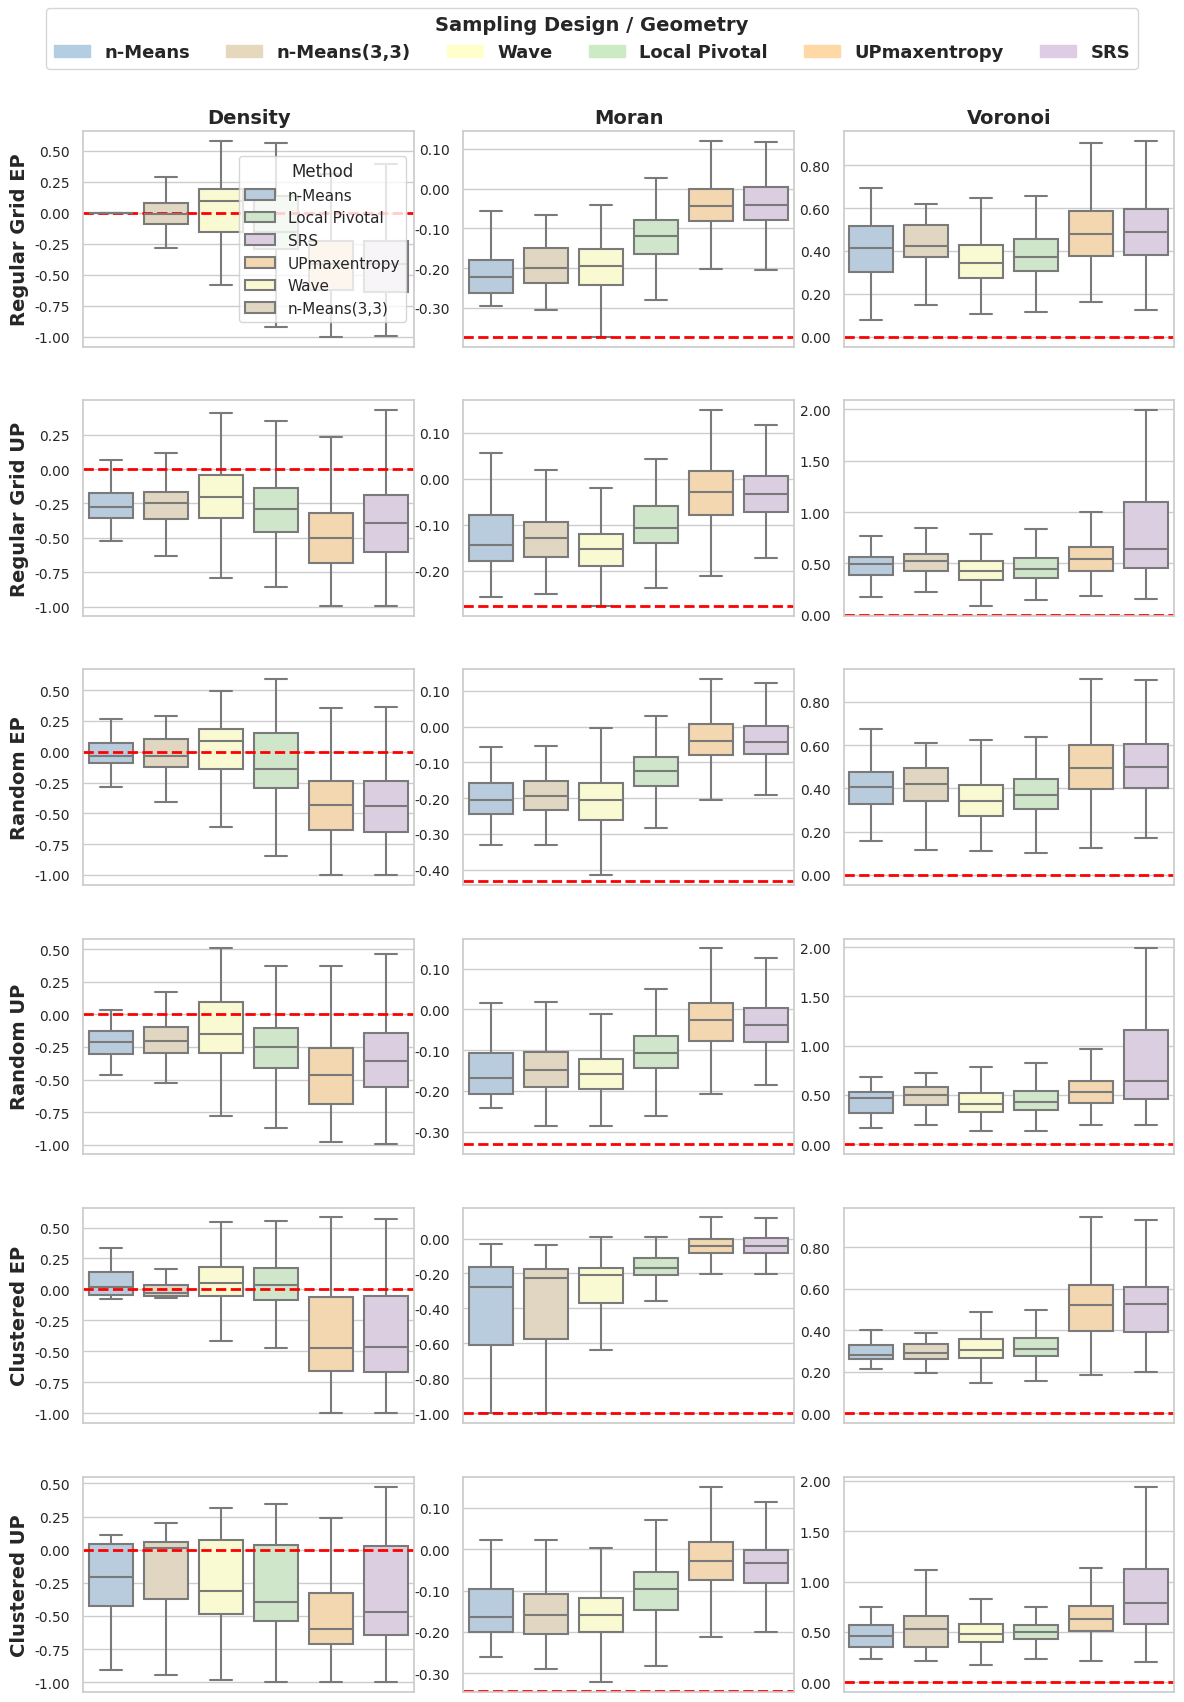

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

# Folder and file info
results_folder = '/home/divar/projects/geometric-sampling/data_samples/results'
result_files = [
    "cleaned_results_grid_eq.csv",
    "cleaned_results_grid_uneq.csv",
    "cleaned_results_random_eq.csv",
    "cleaned_results_random_uneq.csv",
    "cleaned_results_clust_eq.csv",
    "cleaned_results_clust_uneq.csv",
]

pretty_names = {
    "grid_eq": "Regular Grid EP",
    "grid_uneq": "Regular Grid UP",
    "random_eq": "Random EP",
    "random_uneq": "Random UP",
    "clust_eq": "Clustered EP",
    "clust_uneq": "Clustered UP",
}

# For display
pop_names = [s.replace("cleaned_results_", "").replace(".csv", "") for s in result_files]

# Mapping for all names (methods and shapes!)
method_name_mapping = {
    "K-Means (33rand)": "n-Means(3,3)",
    "K-Means (3, 3)": "n-Means",
    "Local Pivotal": "Local Pivotal",
    "Random": "SRS",
    "UPmaxentropy": "UPmaxentropy",
    "wave": "Wave",
    #"cube": "Cube"
}
# desired consistent plotting order
method_order = [
     "n-Means", "n-Means(3,3)", "Wave", "Local Pivotal", "UPmaxentropy", "SRS", 
]

# Read results into a dict, fix column names
results_dict = {}
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname), header=None)
    # Name columns the same way as in cleaning script
    df.columns = ["Method", "Density", "Moran", "Local Balanced"]
    # Map pretty method names (including shapes)
    df["Method"] = df["Method"].map(method_name_mapping)
    results_dict[name] = df

# All method labels present
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel1", n_colors=len(all_methods))))
# Metrics (ensure correct order: Density, Moran, Local Balanced)
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname), header=None)
    df.columns = ["Method", "Density", "Moran", "Local Balanced"]
    df.rename(columns={"Local Balanced": "Voronoi"}, inplace=True)
    df["Method"] = df["Method"].map(method_name_mapping)
    results_dict[name] = df

columns = ["Density", "Moran", "Voronoi"]
# Create 6 populations x 3 metrics grid
n_rows = len(pop_names)
n_cols = len(columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]
        sns.boxplot(
            x="Method",
            y=metric,
            data=df_pop[df_pop[metric].astype(float) < 2],  # filter big outliers if any
            hue="Method",
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5,
        )
        ax.tick_params(axis='x', length=0)
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=14)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        if not (row_idx == 0 and col_idx == 0):
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))  # 2 decimals
        if metric == "Moran":
            ax.axhline(y=min(df_pop['Moran']), color='red', linestyle='--', linewidth=2)
        else:
            ax.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Shared legend
from matplotlib.patches import Patch
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)
labels = [m for m in method_order if m in all_methods]
handles = [Patch(color=method_palette[m]) for m in labels]

leg = fig.legend(
    handles, labels, loc='upper center', ncol=len(method_order),
    title="Sampling Design / Geometry", fontsize=13, title_fontsize=14
)
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')

fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(wspace=0.15, hspace=0.25)
plt.show()

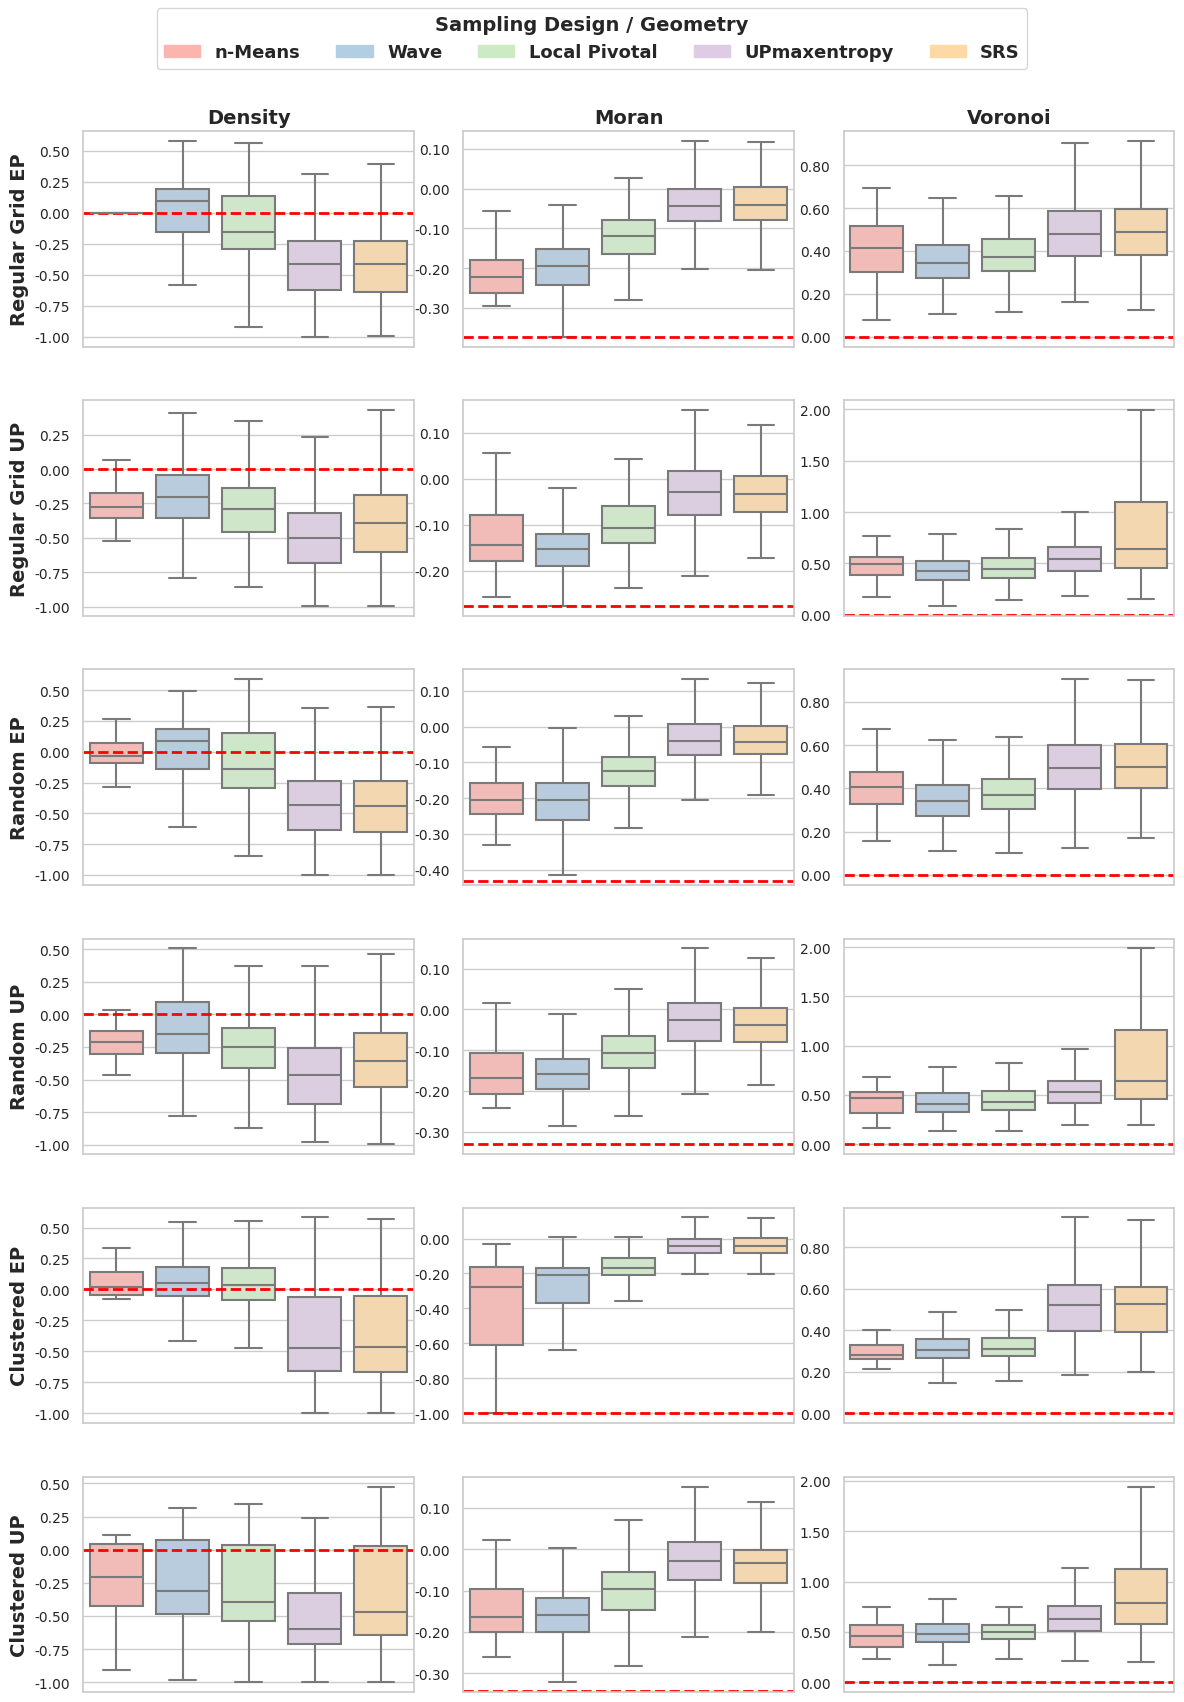

In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

show_centroid_scores = False  # Set to False to skip centroid scores
show_means = False  # Set to False to skip means in plots
filter_outliers = False  # Set to False to skip filtering outliers
sns.set(style="whitegrid")

results_folder = '/home/divar/projects/geometric-sampling/data_samples/results'
result_files = [
    "cleaned_results_grid_eq.csv",
    "cleaned_results_grid_uneq.csv",
    "cleaned_results_random_eq.csv",
    "cleaned_results_random_uneq.csv",
    "cleaned_results_clust_eq.csv",
    "cleaned_results_clust_uneq.csv",
]

pretty_names = {
    "grid_eq": "Regular Grid EP",
    "grid_uneq": "Regular Grid UP",
    "random_eq": "Random EP",
    "random_uneq": "Random UP",
    "clust_eq": "Clustered EP",
    "clust_uneq": "Clustered UP",
}
pop_names = [s.replace("cleaned_results_", "").replace(".csv", "") for s in result_files]

method_name_mapping = {
    #"K-Means (33rand)": "n-Means(3,3)",
    "K-Means (3, 3)": "n-Means",
    "Local Pivotal": "Local Pivotal",
    "Random": "SRS",
    "UPmaxentropy": "UPmaxentropy",
    "wave": "Wave",
    #"cube": "Cube"
}
method_order = [
    "n-Means", "Wave", "Local Pivotal", "UPmaxentropy", "SRS",
]

# --- 1. Load your data ---
results_dict = {}
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname), header=None)
    df.columns = ["Method", "Density", "Moran", "Local Balanced"]
    df.rename(columns={"Local Balanced": "Voronoi"}, inplace=True)
    df["Method"] = df["Method"].map(method_name_mapping)
    results_dict[name] = df

all_methods = pd.concat(list(results_dict.values()))["Method"].dropna().unique()
columns = ["Density", "Moran", "Voronoi"]
n_rows = len(pop_names)
n_cols = len(columns)
method_palette = dict(zip(method_order, sns.color_palette("Pastel1", n_colors=len(method_order))))

# --- 2. Calculate "centroid" sample scores for each method/pop (with closest available points and no duplicates)
coord_folder = "/home/divar/projects/geometric-sampling/data_samples/coords_probs"
centroid_scores = {pop: {} for pop in pop_names}

for pop in pop_names:
    coords_probs_file = os.path.join(coord_folder, f"{pop}.csv")
    df_pop_input = pd.read_csv(coords_probs_file)
    coords = df_pop_input[["x", "y"]].values
    probs = df_pop_input["prob"].values
    n = int(np.round(probs.sum()))
    N = len(probs)

    methods = results_dict[pop]["Method"].unique()
    for method in methods:
        if not isinstance(method, str) or method.strip() == "" or pd.isna(method):
            continue
        if show_centroid_scores:
            if method == "n-Means":
                sampler = gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=(3, 3), tolerance=3, split_size=.001)
                centroids = np.array([cluster.units[:, 1:3].mean(axis=0)
                                    for cluster in sampler.popu.clusters if len(cluster.units) > 0])
                # Select closest unique points to the centroids
                sample_idx = []
                used = set()
                for centroid in centroids:
                    dists = np.linalg.norm(coords - centroid, axis=1)
                    for idx in np.argsort(dists):
                        if idx not in used:
                            sample_idx.append(idx)
                            used.add(idx)
                            break
                sample_idx = np.array(sample_idx)
            elif method == "n-Means(3,3)":
                sampler = gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=(3, 3), tolerance=3, split_size=.001)
                centroids = np.array([cluster.units[:, 1:3].mean(axis=0)
                                    for cluster in sampler.popu.clusters if len(cluster.units) > 0])
                sample_idx = []
                used = set()
                for centroid in centroids:
                    dists = np.linalg.norm(coords - centroid, axis=1)
                    for idx in np.argsort(dists):
                        if idx not in used:
                            sample_idx.append(idx)
                            used.add(idx)
                            break
                sample_idx = np.array(sample_idx)
            elif method == "Local Pivotal":
                continue
            elif method == "SRS":
                continue
            elif method == "UPmaxentropy":
                continue
            elif method == "Wave":
                continue
            else:
                continue

            density_measure = None
            try:
                density, moran, voronoi = scores(
                    coords, probs, n, N, sample_idx, split_size=.001, density_measure=density_measure
                )
            except Exception as e:
                print(f"Score computation failed for {pop} {method}: {e}")
                density, moran, voronoi = np.nan, np.nan, np.nan

            centroid_scores[pop][method] = [density, moran, voronoi]


# --- 3. Plotting ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        if filter_outliers:
            df_pop = df_pop[
            (df_pop[metric].astype(float) >= df_pop[metric].astype(float).quantile(0.1)) &
            (df_pop[metric].astype(float) <= df_pop[metric].astype(float).quantile(0.9)) &
            (df_pop[metric].astype(float) < 2)
                                ]
        ax = axes[row_idx, col_idx]
        sns.boxplot(
            x="Method",
            y=metric,
            data=df_pop[df_pop[metric].astype(float) < 2],
            hue="Method",
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5,
        )
        # Remove any legend produced
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

        # ---- Add MEANS as dots ----
        if show_means:
            means = df_pop[df_pop[metric].astype(float) < 2].groupby("Method")[metric].mean()
            xpos_map = {name: i for i, name in enumerate(method_order)}
            for method, mean_val in means.items():
                if method in xpos_map and not pd.isna(mean_val):
                    xpos = xpos_map[method]
                    ax.scatter(xpos, mean_val, color='blue', marker='D', s=10, zorder=10)
        
        ax.tick_params(axis='x', length=0)
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=14)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))
        if metric == "Moran":
            ax.axhline(y=min(df_pop['Moran']), color='red', linestyle='--', linewidth=2)
        else:
            ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
        # Add centroid sample's score as a horizontal line (black)
        for m in method_order:
            if m in centroid_scores[pop] and not np.isnan(centroid_scores[pop][m][col_idx]):
                score_val = centroid_scores[pop][m][col_idx]
                ax.axhline(score_val, color="black", linestyle=":", linewidth=2, alpha=0.85, zorder=20)

# --------- Ensure all legends in subplots are removed AGAIN (just in case) ---------
for ax_row in axes if n_rows > 1 else [axes]:
    for ax in (ax_row if n_cols > 1 else [ax_row]):
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

# Shared legend at the top
from matplotlib.patches import Patch
labels = [m for m in method_order if m in all_methods]
handles = [Patch(color=method_palette[m]) for m in labels]

leg = fig.legend(
    handles, labels, loc='upper center', ncol=len(method_order),
    title="Sampling Design / Geometry", fontsize=13, title_fontsize=14
)
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')

fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(wspace=0.15, hspace=0.25)
plt.show()

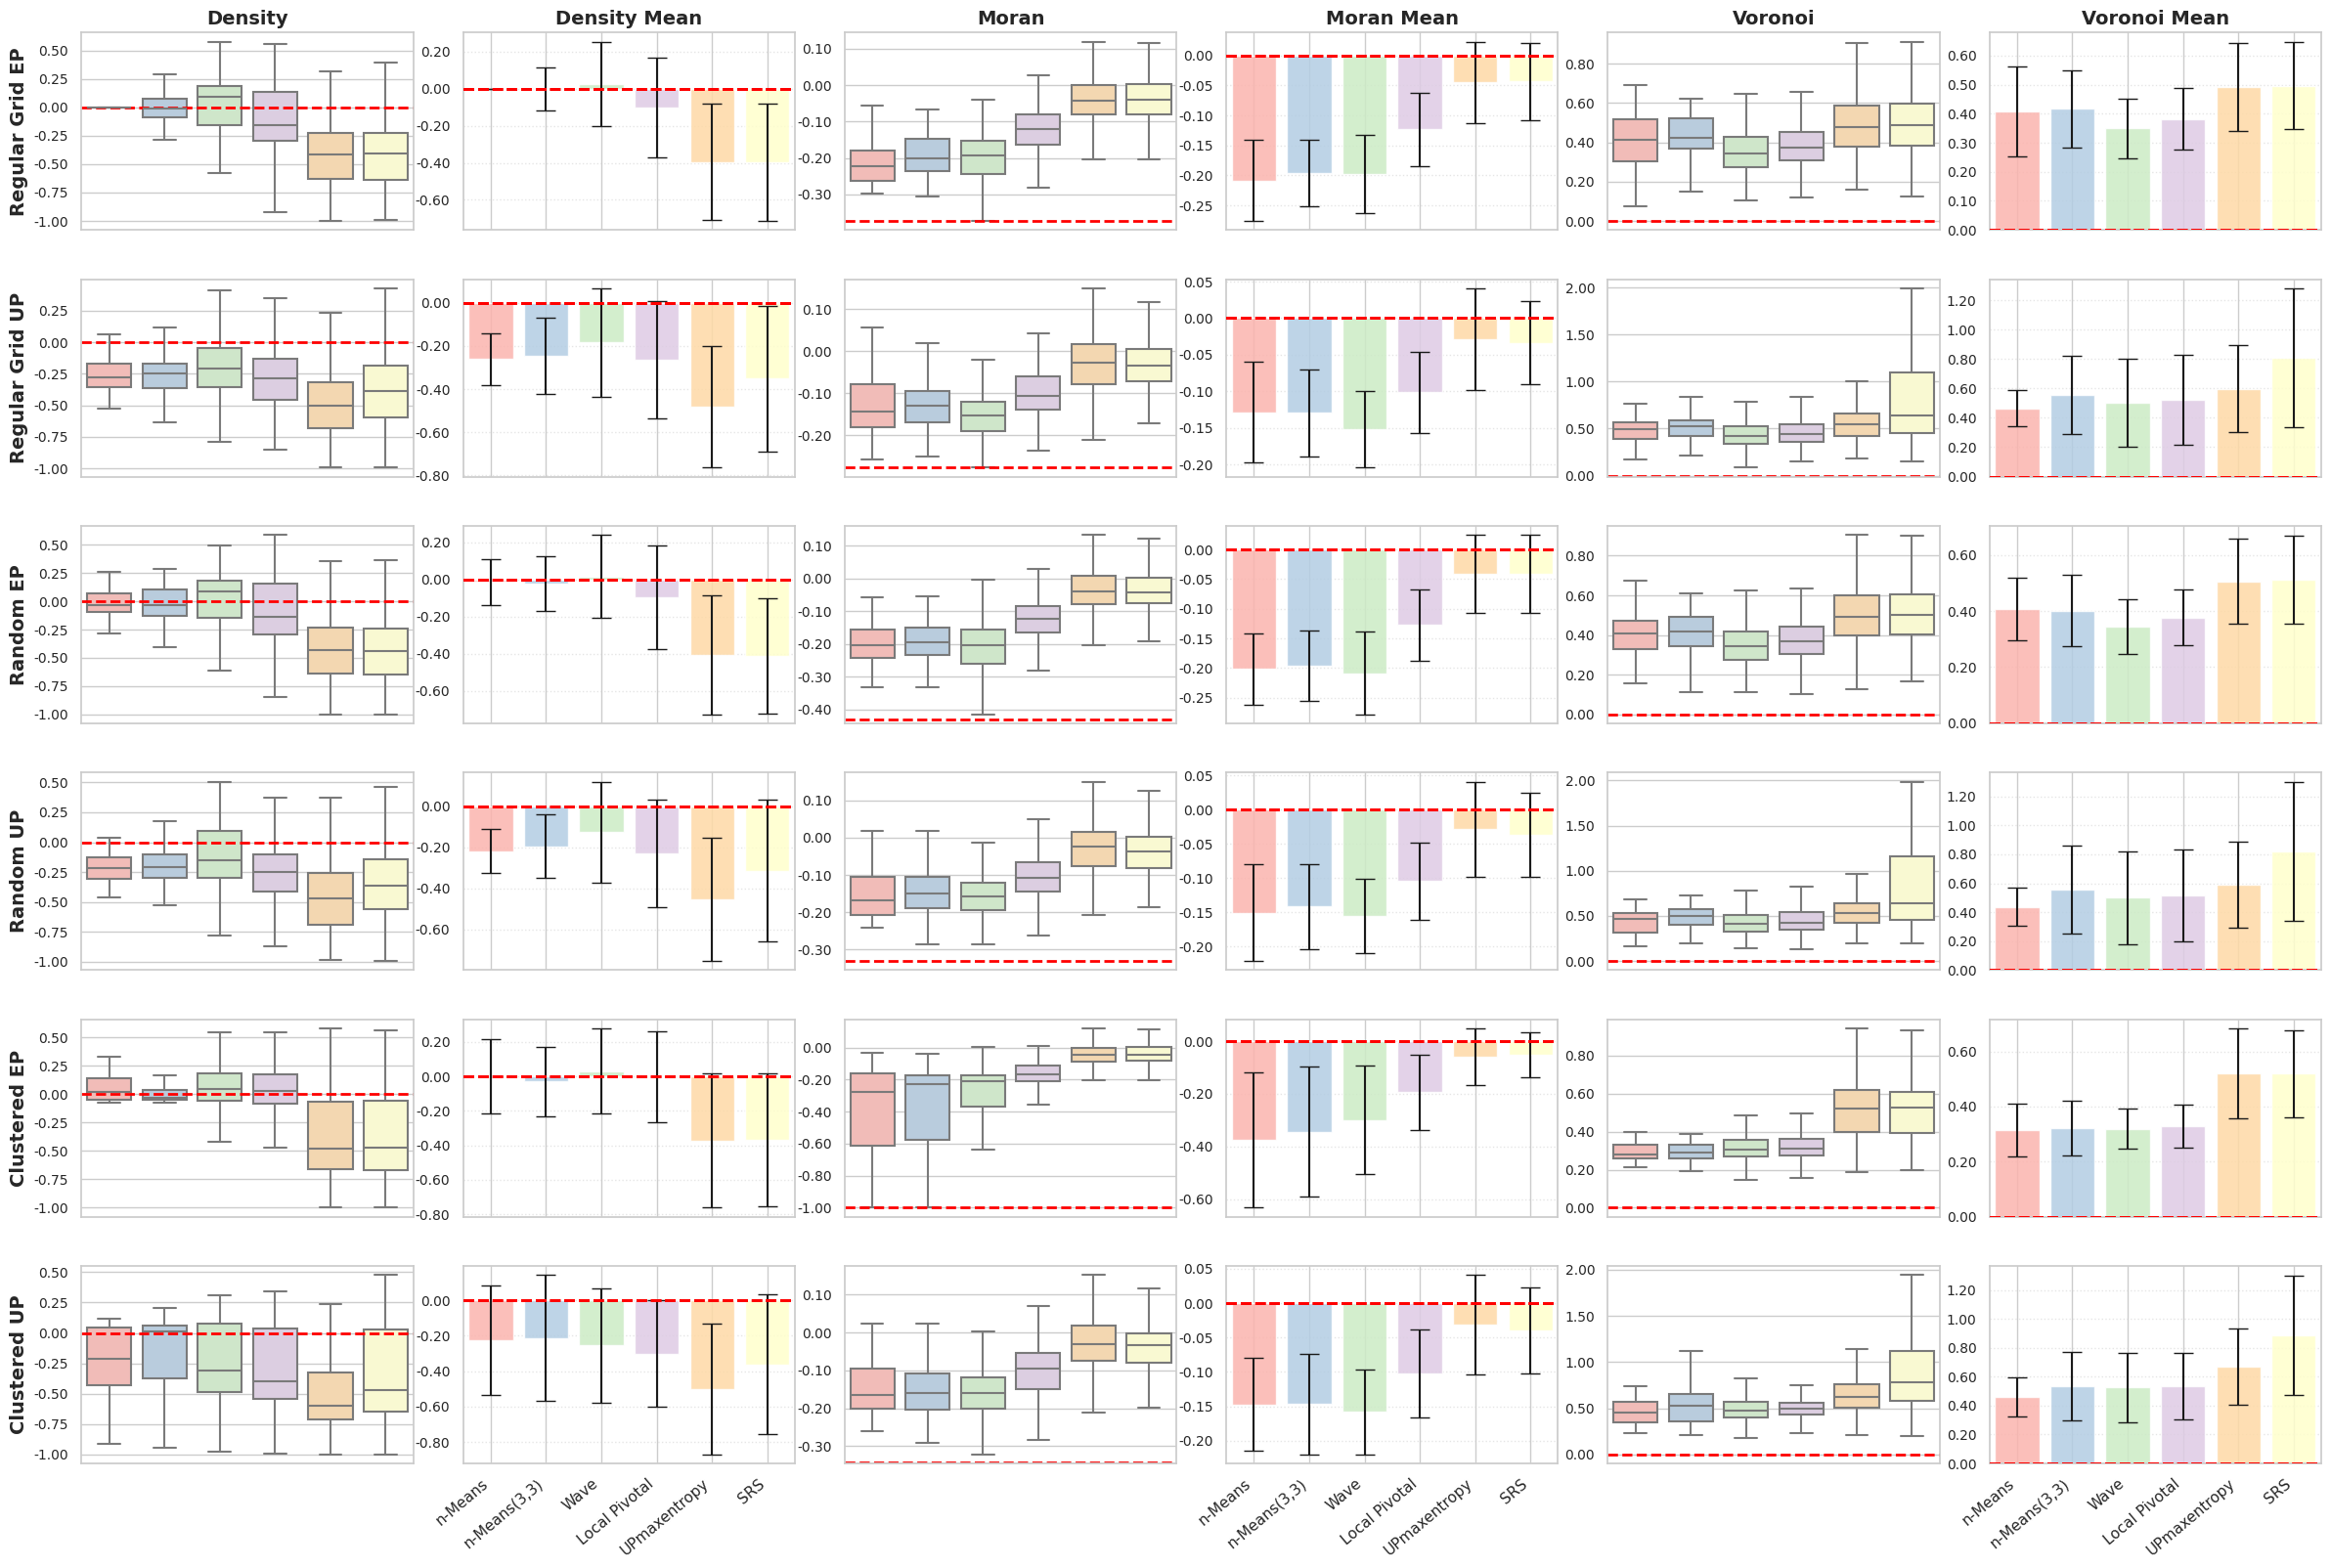

In [ ]:
# --- 3. Plotting ---

n_plot_cols = n_cols * 2  # For each metric: boxplot + mean bar

fig, axes = plt.subplots(n_rows, n_plot_cols, figsize=(4*n_plot_cols, 3*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        # --- Optionally FILTER OUTLIERS ---
        df_filtered = df_pop.copy()
        if filter_outliers:
            q_low = df_filtered[metric].astype(float).quantile(0.1)
            q_high = df_filtered[metric].astype(float).quantile(0.9)
            df_filtered = df_filtered[
                (df_filtered[metric].astype(float) >= q_low) &
                (df_filtered[metric].astype(float) <= q_high) &
                (df_filtered[metric].astype(float) < 2)
            ]
        else:
            df_filtered = df_filtered[df_filtered[metric].astype(float) < 2]

        # ---------------- First Subplot: BOXPLOT ----------------
        ax_box = axes[row_idx, col_idx*2]
        sns.boxplot(
            x="Method",
            y=metric,
            data=df_filtered,
            hue="Method",
            palette=method_palette,
            ax=ax_box,
            order=method_order,
            showfliers=False,
            linewidth=1.5,
        )
        # Remove legend from boxplot
        legend = ax_box.get_legend()
        if legend: legend.remove()

        # Means as blue dots (if enabled)
        if show_means:
            means = df_filtered.groupby("Method")[metric].mean()
            xpos_map = {name: i for i, name in enumerate(method_order)}
            for method, mean_val in means.items():
                if method in xpos_map and not pd.isna(mean_val):
                    xpos = xpos_map[method]
                    ax_box.scatter(xpos, mean_val, color='blue', marker='D', s=10, zorder=10)

        ax_box.tick_params(axis='x', length=0)
        if row_idx == 0:
            ax_box.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax_box.set_title("")
        if col_idx == 0:
            ax_box.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=14)
        else:
            ax_box.set_ylabel("")
        ax_box.set_xlabel("")
        ax_box.set_xticklabels([])
        ax_box.tick_params(axis='y', labelsize=10)
        ax_box.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))
        if metric == "Moran":
            ax_box.axhline(y=min(df_filtered['Moran']), color='red', linestyle='--', linewidth=2)
        else:
            ax_box.axhline(y=0, color='red', linestyle='--', linewidth=2)
        for m in method_order:
            if m in centroid_scores[pop] and not np.isnan(centroid_scores[pop][m][col_idx]):
                score_val = centroid_scores[pop][m][col_idx]
                ax_box.axhline(score_val, color="black", linestyle=":", linewidth=2, alpha=0.85, zorder=20)

        # ---------------- Second Subplot: MEAN BAR ----------------
        ax_bar = axes[row_idx, col_idx*2+1]

        bar_means = []
        bar_stds = []
        df_metric = df_filtered
        for m in method_order:
            vals = df_metric[df_metric["Method"] == m][metric].astype(float).dropna()
            bar_means.append(vals.mean() if len(vals) > 0 else np.nan)
            bar_stds.append(vals.std() if len(vals) > 0 else np.nan)
        
        x = np.arange(len(method_order))
        bars = ax_bar.bar(
            x, bar_means, yerr=bar_stds, align='center', 
            color=[method_palette[m] for m in method_order], capsize=7, alpha=.85, zorder=2
        )
        # ONE dashed line at mean of each bar
        for idx, mean in enumerate(bar_means):
            if not np.isnan(mean):
                ax_bar.axhline(0, color='red', ls='--', lw=2, zorder=5)
        ax_bar.set_xticks(x)
        # Labels shown only on bottom row
        if row_idx == (n_rows-1):
            ax_bar.set_xticklabels(method_order, rotation=40, ha='right', fontsize=11)
        else:
            ax_bar.set_xticklabels([])
        if row_idx == 0:
            ax_bar.set_title(f"{metric} Mean", fontsize=14, weight='bold')
        else:
            ax_bar.set_title('')
        ax_bar.set_xlabel("")
        ax_bar.set_ylabel("")
        ax_bar.tick_params(axis='y', labelsize=10)
        ax_bar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))
        ax_bar.set_xlim(-0.5, len(x)-0.5)

        # Optional: lightly grid the y axis
        ax_bar.grid(True, axis='y', linestyle=':', alpha=0.5)
        # No legend!
        legend = ax_bar.get_legend()
        if legend is not None:
            legend.remove()

# --------- Remove any legends ---------
for ax_row in axes if n_rows > 1 else [axes]:
    for ax in (ax_row if n_plot_cols > 1 else [ax_row]):
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(wspace=0.15, hspace=0.25)
plt.show()